#  Validation of a Phase Modulator against experimental data
In this notebook we construct a phase modulator and validate the numerical results against the experimental data provided in [1]. The modulator consists of a pn junction with high doping at the contact areas to allow for a less resistive contact. The sketch below illustrate the main dimensions of the modulator.

![Modulator]("modulator.png")

The first part of this notebook illustrates how to set up a Charge simulation in Tidy3d. For this example, the isothermal Drift-Diffusion (DD) equations are solved. A basic summary of the equations solved and nomenclature used can be found our [dicumentation](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/_autosummary/tidy3d.SemiconductorMedium.html#tidy3d.SemiconductorMedium). 

The second part of the notebook shows how the output from a Charge simulation can be used to determine the optical phase change.

[1] Chrostowski L, Hochberg M. Silicon Photonics Design: From Devices to Systems. Cambridge University Press; 2015.

## Charge simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from generate_mesh import gen_mesh

import devsim as ds

Let's first define some dimensions. As with the rest of Tidy3d, the dimensions are assumed to be in micro-meters.

Since 2D problems are not yet supported, we will extrude our problem in the z dimension (perpendicular to the plane of the problem) in `z_size` $\mu m$.

In [2]:
# all units in um
w_core = 0.25
h_core = 0.22

w_clearance = 2.25
h_clearance = 0.09
w_side = 2.5
h_side = 0.22

w_contact = 1.2
h_contact = 1.

z_size = h_clearance/5

res = h_clearance/10

### Create mediums

In [3]:
# if the frequency range were valid to 0 we could define the material as
SiO2_optic = td.material_library['SiO2']['Palik_Lossless']
SiO2 = td.MultiPhysicsMedium(
    optical=SiO2_optic,
    charge=td.ChargeInsulatorMedium(permittivity=SiO2_optic.eps_model(frequency=0)), 
    name="SiO2",
)

# Let's create our own material since
#    1. The above material is not well defined for frequency=0 (out of validity region)
#    2. The mode solver doesn't yet support Multiphysics mediums
SiO2 = td.MultiPhysicsMedium(
    optical=td.Medium(permittivity=3.9),
    charge=td.ChargeInsulatorMedium(permittivity=3.9), # redefining permittivity
    name="SiO2",
)

# auxiliary materials we use to define BCs
aux_left = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1),
    name="aux_left"
)

aux_right = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1),
    name="aux_right"
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

17:51:53 CET WARNING: frequency passed to 'Medium.eps_model()'is outside of     
             'Medium.frequency_range' = (59958491600000.0, 1998616386666666.8)  

/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/pydantic/v1/validators.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


#### Semiconductor medium

We will begin defining the intrinsic semiconductor, i.e., the semiconductor medium without any doping. This intrinsic semiconductor will be defined with the required models, i.e., [mobility](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/charge/index.html#mobility), [bandgap narrowing](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/charge/index.html#bandgap), and [generation-recombination](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/charge/index.html#generation-recombination) models.

Since our waveguide semiconductor material is silicon we can simply get semiconductor properties from our material library:

In [4]:
intrinsic_si = td.material_library['cSi'].variants['Si_MultiPhysics'].medium.charge


In case we want to build our own semiconductor medium, we can do so in the following manner (note that is identical to the one above):

In [5]:
# Create a semiconductor medium with mobility, generation-recombination, and bandgap narrowing models.
intrinsic_si = td.SemiconductorMedium(
    permittivity=11.7,
    N_c=2.86e19,
    N_v=3.1e19,
    E_g=1.11,
    mobility=td.CaugheyThomasMobility(
        mu_n_min=52.2,
        mu_n=1471.0,
        mu_p_min=44.9,
        mu_p=470.5,
        exp_t_mu=-2.33,
        exp_d_n=0.68,
        exp_d_p=0.719,
        ref_N=2.23e17,
        exp_t_mu_min=-0.57,
        exp_t_d=2.4,
        exp_t_d_exp=-0.146,
    ),
    R=[
        td.ShockleyReedHallRecombination(tau_n=3.3e-6, tau_p=4e-6),
        td.RadiativeRecombination(r_const=1.6e-14),
        td.AugerRecombination(c_n=2.8e-31, c_p=9.9e-32),
    ],
    delta_E_g=td.SlotboomBandGapNarrowing(
        v1=6.92 * 1e-3,
        n2=1.3e17,
        c2=0.5,
        min_N=1e15,
    ),
    N_a=0,
    N_d=0,
)


Note that no acceptors nor donors are defined in the previous semiconductor medium specification, i.e., `N_a=0` and `N_d=0`.

Since we will be [doping](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/charge/index.html#doping) our semiconductors with acceptors and donors, let's create the doping distributions first. To do this, we'll use Gaussian doping boxes. How these boxes work can be seen in the [dcumentation](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/_autosummary/tidy3d.GaussianDoping.html#tidy3d.GaussianDoping).

In [6]:
# doping with boxes
acceptor_boxes = []
donor_boxes = []

acceptor_boxes.append(td.ConstantDoping(box_coords=[[-5, 0, 0],[5, 0.22, 0]], concentration=1e15))

# p implant
acceptor_boxes.append(td.GaussianDoping(
    box_coords=[[-6, -0.3, 0],[-0.15, 0.098, 0]], 
    concentration=7e17,
    ref_con=1e6,
    width=0.1,
    source="ymax"))

# n implant
donor_boxes.append(td.GaussianDoping(
    box_coords=[[0.15, -0.3, 0],[6, 0.098, 0]], 
    concentration=5e17,
    ref_con=1e6,
    width=0.1,
    source="ymax") )

# p++
acceptor_boxes.append(td.GaussianDoping(
    box_coords=[[-6, -0.3, 0],[-2, 0.22, 0]], 
    concentration=1e19,
    ref_con=1e6,
    width=0.1,
    source="ymax"))

# n++
donor_boxes.append(td.GaussianDoping(
    box_coords=[[2, -0.3, 0],[6, 0.22, 0]], 
    concentration=1e19,
    ref_con=1e6,
    width=0.1,
    source="ymax"))


# p wg implant
acceptor_boxes.append(td.GaussianDoping(
    box_coords=[[-0.3, 0, 0],[0.06, 0.255, 0]], 
    concentration=5e17,
    ref_con=1e6,
    width=0.12,
    source="xmin"))

# n wg implant
donor_boxes.append(td.GaussianDoping(
    box_coords=[[-0.06, 0.02, 0],[0.25, 0.26, 0]], 
    concentration=7e17,
    ref_con=1e6,
    width=0.11,
    source="xmax"))


Once we have out doping we can add it to our semiconductor material and create our `MultiphysicsMedium` which we'll use in our simulation. Note that to include the doping to our semiconductor properties, we're actually creating a copy of it through the function `updated_copy()`.

In [7]:
Si_2D_doping = td.MultiPhysicsMedium(
    charge=intrinsic_si.updated_copy(
        N_d=donor_boxes,
        N_a=acceptor_boxes,
    ),
    name="Si_doping",
)

### Generate structures
We can now create the structures that compose our modulator

In [8]:
# create objects
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(10, 5, z_size)),
    medium=SiO2,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_n"
)

# create a couple structs to define the contacts
contact_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side + w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_left,
    name="contact_p"
)

contact_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side - w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_right,
    name="contact_n"
)


We can first create a scene to make sure our structures are well positioned:

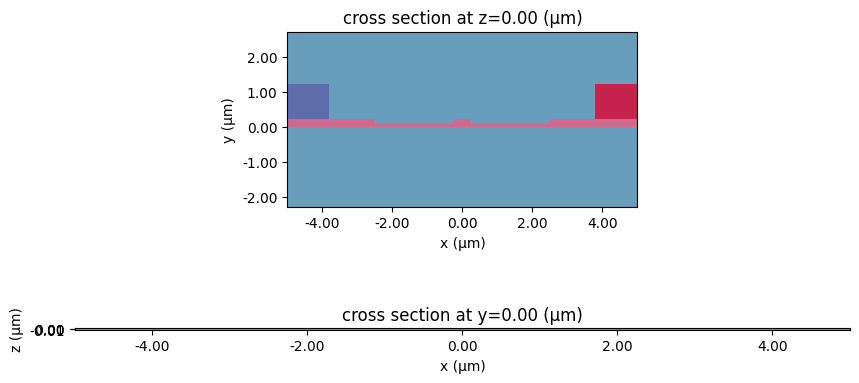

In [9]:
# create a scene with the previous structures
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n, contact_p, contact_n]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(10, 5))

scene.plot(z=0, ax=ax[0])
scene.plot(y=5e-6, ax=ax[1])
plt.show()


And to make sure our doping is correct, we can visualize doping concentrations with the convencience function `plot_structures_property()`. 

**Note**: In the plots below, we have use `property="doping"` but we can also use `property="acceptors"` or `property="donors"` to check individual dopants. 

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

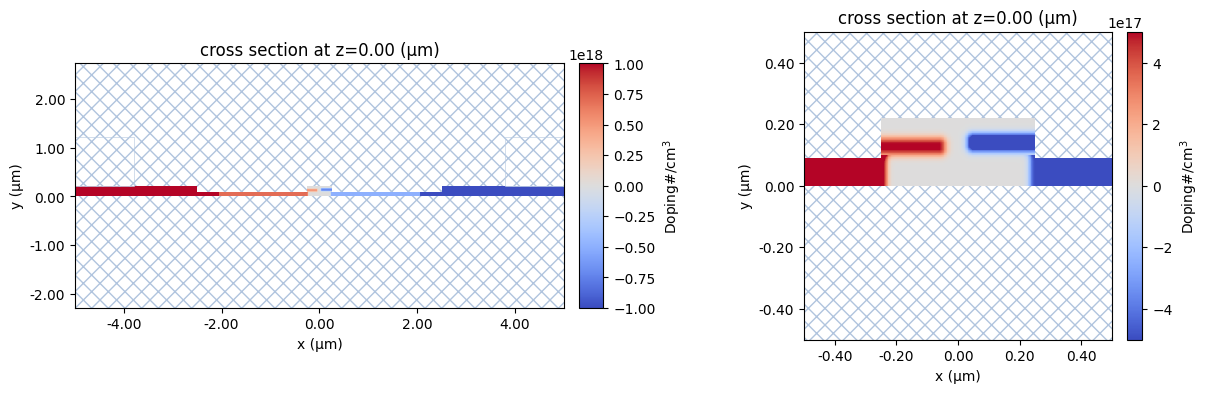

In [10]:
# plot doping from scene
_, ax = plt.subplots(1,2, figsize=(15, 4))
scene.plot_structures_property(z=0, property="doping", ax=ax[0], limits=[-1e18,1e18])
scene.plot_structures_property(z=0, property="doping", ax=ax[1], hlim=[-0.5,0.5], vlim=[-0.5,0.5], limits=[-5e17,5e17])


### BCs
For the current simulation we'll apply a DC voltage at both the p and n sides. We can do this by using the `VoltageBC` class. This class has a `source` member for which we assign a DC source `DCVoltageSource`. The `DCVoltageSource` can accept eiter a single float or an array of floats. In the latter case, a solution for each of the voltages defined in the array will be calculated. 

Since we'll be operating the modulator in reverse bias, we'll assign a zero voltage to the p side and positive voltages to the n side.

In [11]:
# create BCs
voltages = [-0.5, 0, 1, 2, 3, 4]

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureBoundary(structure=contact_p.name),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages)),
    placement=td.StructureBoundary(structure=contact_n.name),
)

boundary_conditions = [bc_v1, bc_v2]

### Monitors
We will use three types of monitors in this notebook, [SteadyCapacitanceMonitor](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/_autosummary/tidy3d.SteadyCapacitanceMonitor.html#tidy3d.SteadyCapacitanceMonitor), [SteadyFreeCarrierMonitor](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/_autosummary/tidy3d.SteadyFreeCarrierMonitor.html#tidy3d.SteadyFreeCarrierMonitor), and [SteadyPotentialMonitor](https://docs.flexcompute.com/projects/tidy3d/en/marc-dd-devsim/api/_autosummary/tidy3d.SteadyPotentialMonitor.html#tidy3d.SteadyPotentialMonitor). 

`SteadyCapacitanceMonitor` is used to monitor small signal capacitance within the area/volume defined by the monitor. See the documentation for further details on how this is calculated. Note that if only one solution is calculated (one single voltage data point is computed) the output for this monitor will be empty.
`SteadyFreeCarrierMonitor` and `SteadyPotentialMonitor` let us record free carriers (electrons and holes) and electric potential fields, respectively, so that we can visualize results. 

In [12]:
# capacitance monitors
capacitance_global_mnt = td.SteadyCapacitanceMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="capacitance_global_mnt",
)

# charge monitor around the waveguide
capacitance_wvg_mnt = td.SteadyCapacitanceMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="capcitance_wvg_mnt",
)

# charge monitor around the waveguide
charge_3D_mnt = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, td.inf), name="charge_3D_mnt", unstructured=True
)

charge_monitor_z0 = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="charge_z0", unstructured=True, 
)

# voltage monitor around waveguide
voltage_monitor_z0 = td.SteadyPotentialMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="voltage_z0", unstructured=True, 
)

# Will be used later for the mode simulations
charge_monitor_z0_big = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="charge_z0_big", unstructured=True, conformal=True
)

### Mesh and convergence criteria
Before we can actually create the simulation object, we need to define some mesh parameters and convergence/tolerance criteria. One important note here is that in Charge simulations, we need to specify the type of simulation we're interested in running. In this case, we want to run a steady state isothermal analysis which is specified with the class `IsothermalSteadyChargeDCAnalysis`. Note that this class a member `convergence_dv`. To understand how this parameter affects convergence, let's imagine a case where we want to solve for 0V and 20 bias. In this case the solver will first try to solve the 0V bias case and based off of this solution will go ahead and try to solve the 20V bias case. Since these are two very different biases, the solver may find it difficult to solve the second. By setting e.g.,`convergence_dv=10` we'll force the solver to go from 0V to 20V in 10V steps which eases convergence.


In [13]:
# mesh
mesh = td.DistanceUnstructuredGrid(dl_interface=res*1.15, dl_bulk=res*4, distance_interface=0.02*h_side,
    distance_bulk=1*h_side, relative_min_dl=0,
    uniform_grid_mediums=[Si_2D_doping.name],
    non_refined_structures=[oxide.name]
)

# devsim setting 
convergence_settings = td.ChargeToleranceSpec(rel_tol=1e5, abs_tol=3e3, max_iters=400)

# currently we support Isothermal cases only. Temperature in K
analysis_type = td.IsothermalSteadyChargeDCAnalysis(temperature=300, convergence_dv=10, tolerance_settings=convergence_settings)

### Create simulation
We're now ready to create the actual simulation object. 

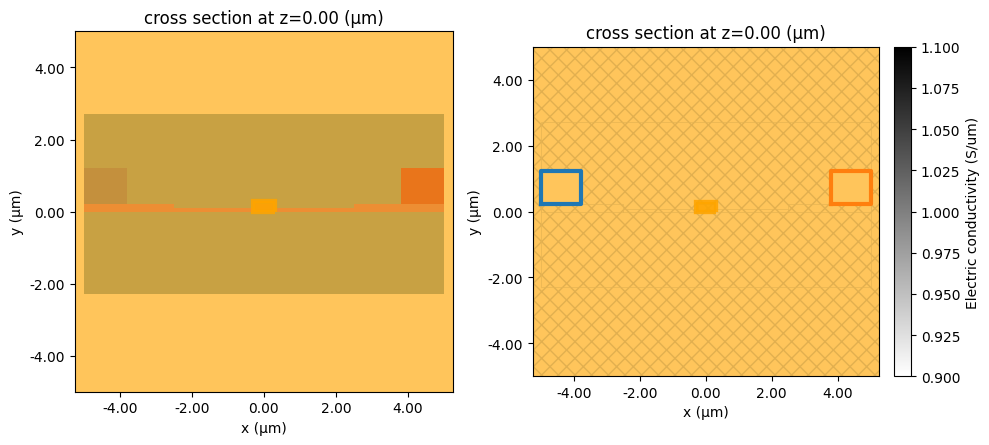

In [14]:
# build heat simulation object
charge_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[capacitance_global_mnt, capacitance_wvg_mnt, charge_3D_mnt, charge_monitor_z0, voltage_monitor_z0, charge_monitor_z0_big],
    analysis_spec=analysis_type,
    center=(0,0,0),
    size=(10.5,10,5),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    symmetry=(0, 0, 0)
    )

# plot simulation
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
charge_sim.plot(z=0, ax=ax[0])
charge_sim.plot_property(z=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()
plt.show()

### Run pipeline

In [15]:
#%matplotlib inline
#from run_drift import run_drift
#charge_data = run_drift(charge_sim)

# run on server
from tidy3d import web
charge_data=web.run(charge_sim, task_name="test_prash", solver_version="dd-devsim-0.0.0", path="charge_web.hdf5")

17:51:59 CET Created task 'test_prash' with task_id                             
             'he-29207f76-e570-465b-ba9b-a0bb6cc734a7' and task_type 'HEAT'.

             Tidy3D's Heat solver is currently in the beta stage. Cost of Heat  
             simulations is subject to change in the future.

             View task using web UI at                                          
             ]8;id=975229;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=495894;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\taskId]8;;\]8;id=975229;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\=]8;;\]8;id=777365;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\he]8;;\]8;id=975229;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\-29207f76-e570-]8;;\
             ]8;id=975229;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\465b-ba9b-a0bb6cc734a7']8;;\.

Output()

17:52:11 CET Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

17:52:12 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:00:00 CET status = preprocess

18:09:59 CET status = postprocess

18:12:24 CET status = success

             starting up solver

18:12:25 CET running solver

             status = success

             View simulation result at                                          
             ]8;id=917336;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=133370;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\taskId]8;;\]8;id=917336;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\=]8;;\]8;id=236915;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\he]8;;\]8;id=917336;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\-29207f76-e570-]8;;\
             ]8;id=917336;https://tidy3d.simulation.cloud/workbench?taskId=he-29207f76-e570-465b-ba9b-a0bb6cc734a7\465b-ba9b-a0bb6cc734a7']8;;\.

Output()

18:12:29 CET loading simulation from charge_web.hdf5

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

### Post-process Charge simmulation
Let's begin by visualizing the potential and electron fields at three different biases to make sure the solution looks reasonable. As it can be seen in the figure, as the (reverse) bias increases, the depletion region widens, as it is expected. The electric potential field also adapts to the applied biases and the amount of charge present in the waveguide area, which is also to be expected. 

/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


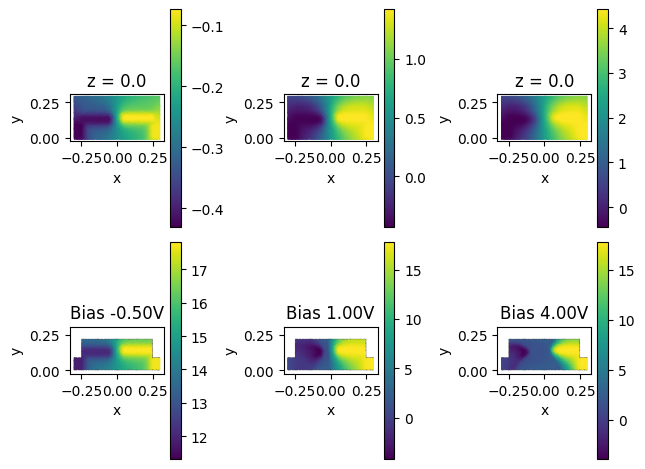

In [16]:
voltages = charge_data[charge_3D_mnt.name].holes.values.voltage.data

fig, ax = plt.subplots(2, 3)
for n, index in enumerate([0,2,5]):
    # let's read voltage first
    charge_data[voltage_monitor_z0.name].potential.sel(voltage=voltages[index]).plot(ax=ax[0][n], grid=False)

    # now let's plot some electrons
    np.log10(charge_data[charge_3D_mnt.name].electrons.sel(z=0, voltage=voltages[index])).plot(ax=ax[1][n], grid=False)
    ax[1][n].set_title("Bias {0:0.2f}V".format(voltages[index]))

plt.tight_layout()

### Comparison against experimental data
In this section we compare small signal capacitance data from our simulation against experimental data. Notice that we are taking the small signal capacitance computed both with electrons and holes and averaged. These should be identical (or close to within convergence tolerance).

As it can be seen, reasonable agreement between experimental and simulation is obtained. 

We take the experimental data from [1]. 

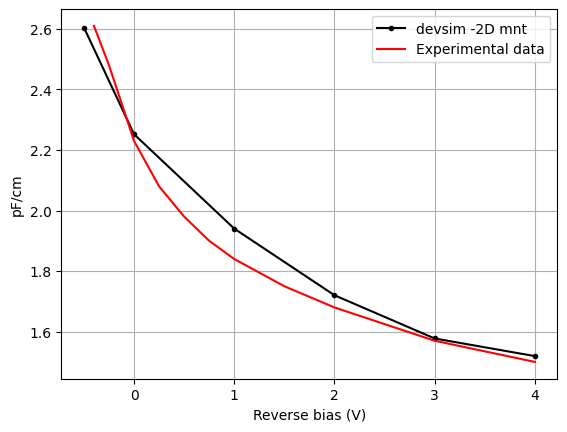

In [17]:
# capacitance from monitor - waveguide area
CV_baehrjones = [
    [-0.4, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4],
    [0.261, 0.248, 0.223, 0.208, 0.198, 0.190, 0.184, 0.175, 0.168, 0.157, 0.150]]


mnt_v = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.coords["v"].data)
mnt_ce = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.data)
mnt_ch = np.array(charge_data[capacitance_global_mnt.name].hole_capacitance.data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10 , 'k.-', label="devsim -2D mnt")
plt.plot(CV_baehrjones[0], np.array(CV_baehrjones[1])*10, 'r-', label="Experimental data")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()

## Generate Charge-dependent perturbation material
Now that we have Charge simulation results, we can study how the free carrier distribution affects the optical properties of the waveguide. We start here by defining a perturbation material:

In [18]:
# define first the range of frequencies of interest

wvl_um = 1.55
freq0 = td.C_0 / wvl_um

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

In [19]:
si = td.material_library['cSi']['Palik_Lossless']

n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)

In [20]:
ne_coeff = -5.4e-22 * 1.1
ne_pow = 1.011

nh_coeff = -1.53e-18 * 1.1
nh_pow = 0.838

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21 * 1.1
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20 * 1.1
kh_pow = 1.109

In [21]:
Ne_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))
Nh_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

dn_mesh = ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
dk_mesh = ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

In [22]:
si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

In [23]:
dn_data = td.ChargeDataArray(dn_mesh, coords=dict(n=Ne_range, p=Nh_range))
dk_data = td.ChargeDataArray(dk_mesh, coords=dict(n=Ne_range, p=Nh_range))

n_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
k_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)

n_si_perturbation = td.ParameterPerturbation(
    charge=n_si_charge,
)

k_si_perturbation = td.ParameterPerturbation(
    charge=k_si_charge,
)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=n_si_perturbation,
        delta_k=k_si_perturbation,
        freq=freq0,
    )
)

## Mode simulation

### Apply perturbation medium to scene
For the optical simulations we will use the previously created perturbation medium. Note that since the optical simulations don't yet support `MultiPhysicsMedium`, we need to change the scene medium:

In [24]:
new_structs = []
for struct in charge_sim.structures:
    # NOTE: applying perturbation material to Si
    if struct.medium.name == Si_2D_doping.name:
        new_structs.append(struct.updated_copy(medium=si_perturb))

scene = td.Scene(
    #medium=td.Medium(permittivity=3.9),
    medium=SiO2.optical, # currently td.Simulation cannot accpet a MultiphysicsMedium
    structures=new_structs,
)


### Create simulation
Let's create an optics simulation object with our updated scene

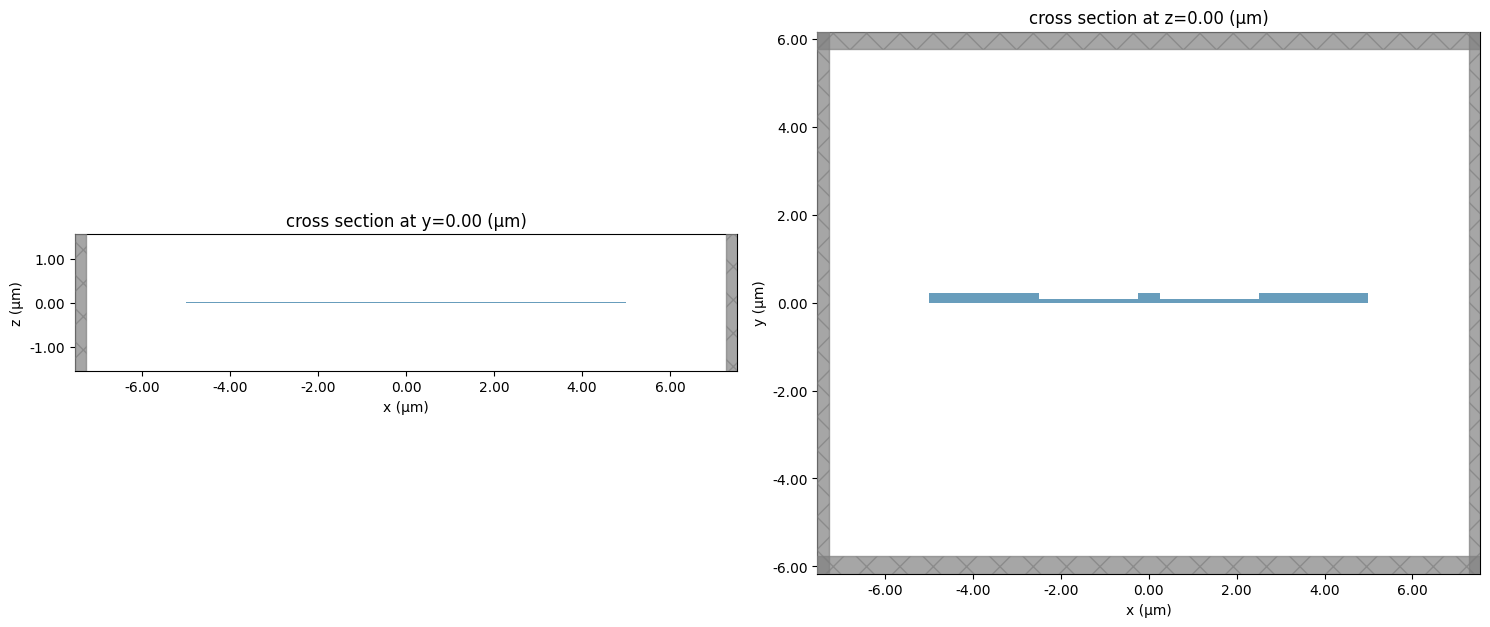

In [25]:
span = 2*wvl_um

port_center = (0,h_core,-span/2)
port_size = (5, 5, 0)

buffer = 1*wvl_um
sim_size = (13+buffer, 10+buffer, span)

bc_spec = td.BoundarySpec(
    x = td.Boundary.pml(num_layers=20),
    y = td.Boundary.pml(num_layers=30),
    z = td.Boundary.periodic(),
)

sim = td.Simulation(
    center=(0,0,0),
    size=sim_size,
    medium=scene.medium,
    structures=scene.structures,
    run_time=6e-12,
    boundary_spec=bc_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=wvl_um)
)

_, ax = plt.subplots(1, 2, figsize=(15, 7))
sim.plot(y=sim.center[1], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

### Apply free carrier fields to perturbation medium
Now that we have the reference optical simulation we can create a list of perturbed optical simulations. We can do this by using the function `perturbed_mediums_copy()`:

In [26]:
def apply_charge(charge_data):
    perturbed_sims = []
    for n, v in enumerate(charge_data[charge_monitor_z0_big.name].electrons.values.voltage.data):
        e_data = charge_data[charge_monitor_z0_big.name].electrons.sel(voltage=v)
        h_data = charge_data[charge_monitor_z0_big.name].holes.sel(voltage=v)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data, 
                hole_density=h_data,
            )
        )
    return perturbed_sims

perturbed_sims = apply_charge(charge_data)

Let's check what the difference in permittivity looks like at different applied voltages:

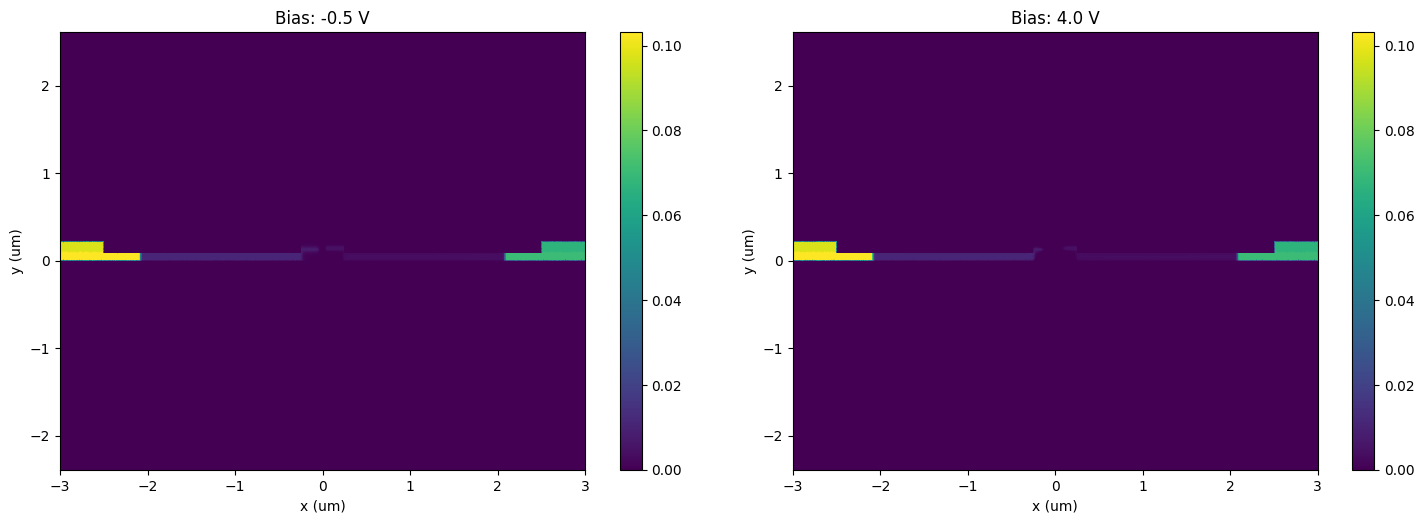

In [27]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

sampling_region = td.Box(center=(0, h_core/2, 0), size=(6, 5, 1))
#eps_undoped = sim.epsilon(box=sampling_region).isel(z=0, drop=True)
eps_undoped = sim.epsilon(box=sampling_region).sel(z=0, method="nearest")

for ax_ind, ind in enumerate([0, len(voltages)-1]):
    #eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).isel(z=0,  drop=True)
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).sel(z=0, method="nearest")
    eps_doped = eps_doped.interp(x=eps_undoped.x, y=eps_undoped.y)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="x", ax=ax[ax_ind])
    
    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

### Waveguide mode analysis
Instead of running a full wave simulation we will compute the modes of the waveguide. This is a smaller computation that will also highlight the influence of free carriers fields over the refraction coefficient.

We will compute the waveguide modes on a plane centered around the core section of the device:

In [28]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run_batch as run_mode_batch

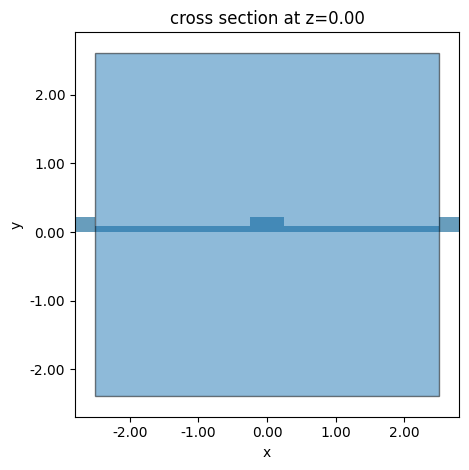

In [29]:
mode_plane = td.Box(center=(0, h_core / 2, 0), size=port_size)

# visualize
ax = sim.plot(z = 0)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

In [30]:
mode_solvers = []
for psim in perturbed_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers.append(ms)

In [31]:
# server mode computation
ms_data = run_mode_batch(mode_solvers=mode_solvers)

18:12:37 CET Running a batch of 6 mode solvers.                                 
             

Output()

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

18:12:38 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

18:12:39 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

18:12:40 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

18:12:41 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

18:16:21 CET A batch of `ModeSolver` tasks completed successfully!

### Relative phase change
Based on the computed refractive index we can now compute both phase shift and loss per cm as a function of the applied bias. As it can be seen, we'd need to apply a bias of ~3V in order to get a phase shift of $\pi$.

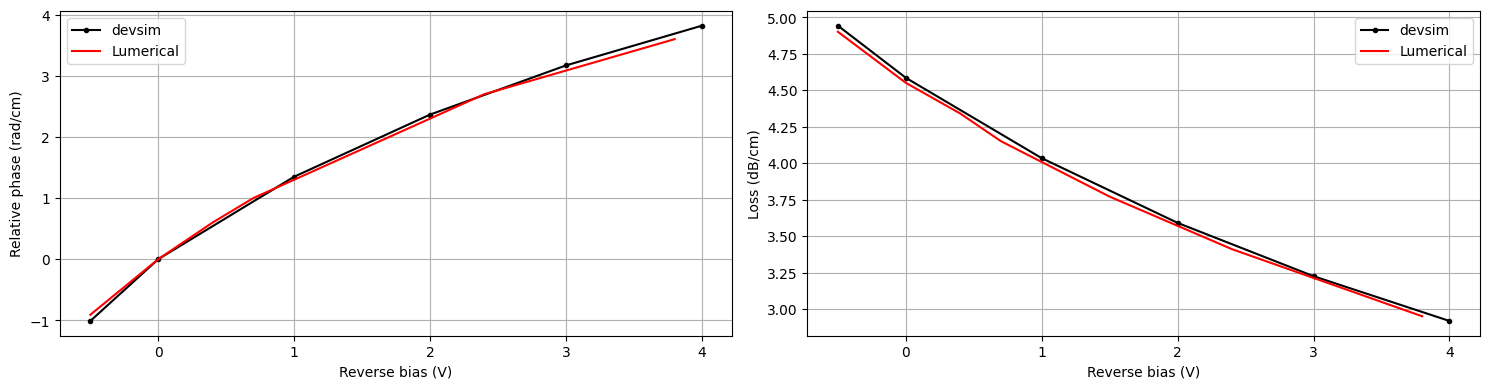

In [32]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_data]

ind_V0 = 1
delta_neff = np.real(n_eff_freq0 - n_eff_freq0[ind_V0])
rel_phase_change = 2*np.pi*delta_neff/wvl_um * 1e4
alpha_dB_cm = 10*4*np.pi*np.imag(n_eff_freq0)/wvl_um*1e4*np.log10(np.exp(1))

# lumerical results
v_lumerical = [-0.5, 0, 0.4, 0.7, 1.5, 2.4, 3.8]
pc_lumerical=[-0.91, 0, 0.6, 1,   1.8, 2.7, 3.6]
loss_lumerical = [4.9, 4.55, 4.34, 4.15, 3.77, 3.41, 2.95]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, rel_phase_change, 'k.-', label="devsim")
ax[0].plot(v_lumerical, pc_lumerical, 'r-', label="Lumerical")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(voltages, alpha_dB_cm, 'k.-', label="devsim")
ax[1].plot(v_lumerical, loss_lumerical, 'r-', label="Lumerical")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()